In [74]:
import matplotlib
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt  # Standard plotting
from matplotlib.animation import FuncAnimation  # Optional: for animations

from shapely.geometry import LineString, Point, MultiPoint, GeometryCollection
from shapely.ops import split
from shapely.strtree import STRtree  # For spatial indexing of geometries
from collections import defaultdict
import networkx as nx # reconstruct network
import random  # For Python’s own RNG (not used yet)

import cv2
from StructuralGT.electronic import Electronic
from StructuralGT.networks import Network

%config InlineBackend.figure_format = 'retina'  # Jupyter setting for high-res inline plots (won’t work in script mode)

In [95]:
# particle dynamics 

class Particle:
    def __init__(self, x, y, p_run, p_tumble, theta, speed, p_link, L_link_mean, L_link_std):
        self.position = np.array([x, y])  # Current position (in unit square)
        self.p_run = p_run  # Probability of running at each timestep
        self.p_tumble = p_tumble  # Probability of tumbling (direction change)
        self.theta = theta  # Current heading (angle in radians)
        self.speed = speed  # Speed per timestep
        self.p_link = p_link  # Probability of laying a link at each timestep
        self.L_link_mean = L_link_mean  # Mean link length
        self.L_link_std = L_link_std  # Std dev of link length

    def maybe_lay_link(self):
        if np.random.rand() < self.p_link:
            # Sample link length from Gaussian, fold negative to positive
            L_link = np.abs(np.random.normal(self.L_link_mean, self.L_link_std))
            return True, L_link
        return False, 0.0

    def run(self, dt):
        if np.random.rand() < self.p_run:
            displacement = self.speed * dt # how far does the particle run?
            dx = displacement * np.cos(self.theta) # change in x coordinate (w/ orientation)
            dy = displacement * np.sin(self.theta) # change in y coordinate (w/ orientation)
            self.position = (self.position + np.array([dx, dy])) % 1.0  # Enforce periodic boundaries

    def tumble(self):
        if np.random.rand() < self.p_tumble:
            self.theta = np.random.uniform(-np.pi, np.pi)  # Randomly sample new direction

edges = []  # List of edges as ((x1, y1), (x2, y2)) tuples
nodes = []  # List of node positions

def add_link(particle, L_link):
    # 1) Compute raw endpoints (may lie outside [0,1]) and center
    dx      = 0.5 * L_link * np.cos(particle.theta)
    dy      = 0.5 * L_link * np.sin(particle.theta)
    centre  = (particle.position % 1.0)            # wrapped center in [0,1]
    
    # Record the node at the deposition site
    nodes.append(centre.copy())

    raw_start = particle.position - np.array([dx, dy])
    raw_end   = particle.position + np.array([dx, dy])
    delta     = raw_end - raw_start

    # helper to wrap a point into [0,1)
    wrap = lambda v: tuple((v % 1.0).tolist())

    # 2) Detect whether we cross a periodic boundary
    wrap_x = abs(delta[0]) > 0.5
    wrap_y = abs(delta[1]) > 0.5
    pieces = []

    if wrap_x:
        # split at the vertical wall x=0 or x=1
        boundary = 1.0 if delta[0] > 0 else 0.0
        t = (boundary - raw_start[0]) / delta[0]
        mid = raw_start + t * delta
        pieces.append((wrap(raw_start), wrap(mid)))
        pieces.append((wrap(mid),       wrap(raw_end)))
    elif wrap_y:
        # split at the horizontal wall y=0 or y=1
        boundary = 1.0 if delta[1] > 0 else 0.0
        t = (boundary - raw_start[1]) / delta[1]
        mid = raw_start + t * delta
        pieces.append((wrap(raw_start), wrap(mid)))
        pieces.append((wrap(mid),       wrap(raw_end)))
    else:
        # no wrap → a single segment
        pieces.append((wrap(raw_start), wrap(raw_end)))

    # 3) Append all resulting edge pieces
    for seg in pieces:
        edges.append(seg)

def simulate(N, steps, dt, particle_params):
    global nodes, edges
    nodes, edges = [], []  # Clear previous run data

    # Create N particles with randomized initial positions and angles
    particles = [
        Particle(
            x=np.random.rand(), y=np.random.rand(),  # Random position
            theta=np.random.uniform(-np.pi, np.pi),  # Random direction
            **particle_params  # Fill in other parameters
        )
        for _ in range(N)
    ]

    for step in range(steps):
        for p in particles:
            laid_link, L_link = p.maybe_lay_link()
            if laid_link:
                add_link(p, L_link)  # Add link if randomly chosen
            p.run(dt)  # Move forward (maybe)
            p.tumble()  # Change direction (maybe)

    # Placeholder for optional post-processing (like merging links)
    #edges[:] = merge_collinear_links(edges)

def plot_network(nodes, edges, step=None, fname='dynamics_1.tif', dpi=300):
    fig = plt.figure(figsize=(6, 6),frameon=False)
    ax = plt.gca()
    for start, end in edges:
        if np.linalg.norm(np.array(start) - np.array(end)) > 0.5:
            continue  # Skip links that wrap around the periodic boundary
        x_vals = [start[0], end[0]]
        y_vals = [start[1], end[1]]
        plt.plot(x_vals, y_vals, 'b-', linewidth=0.5)  # Draw edge as blue line

    plt.gca().set_aspect('equal')  # Keep square aspect ratio
    ax.set_aspect('equal')
    ax.axis('off')  # Hides axes, ticks, and background
    
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    plt.tight_layout(pad=0)
    fig.savefig(fname, bbox_inches='tight', pad_inches=0, transparent=True)
    plt.show()

## Network 1

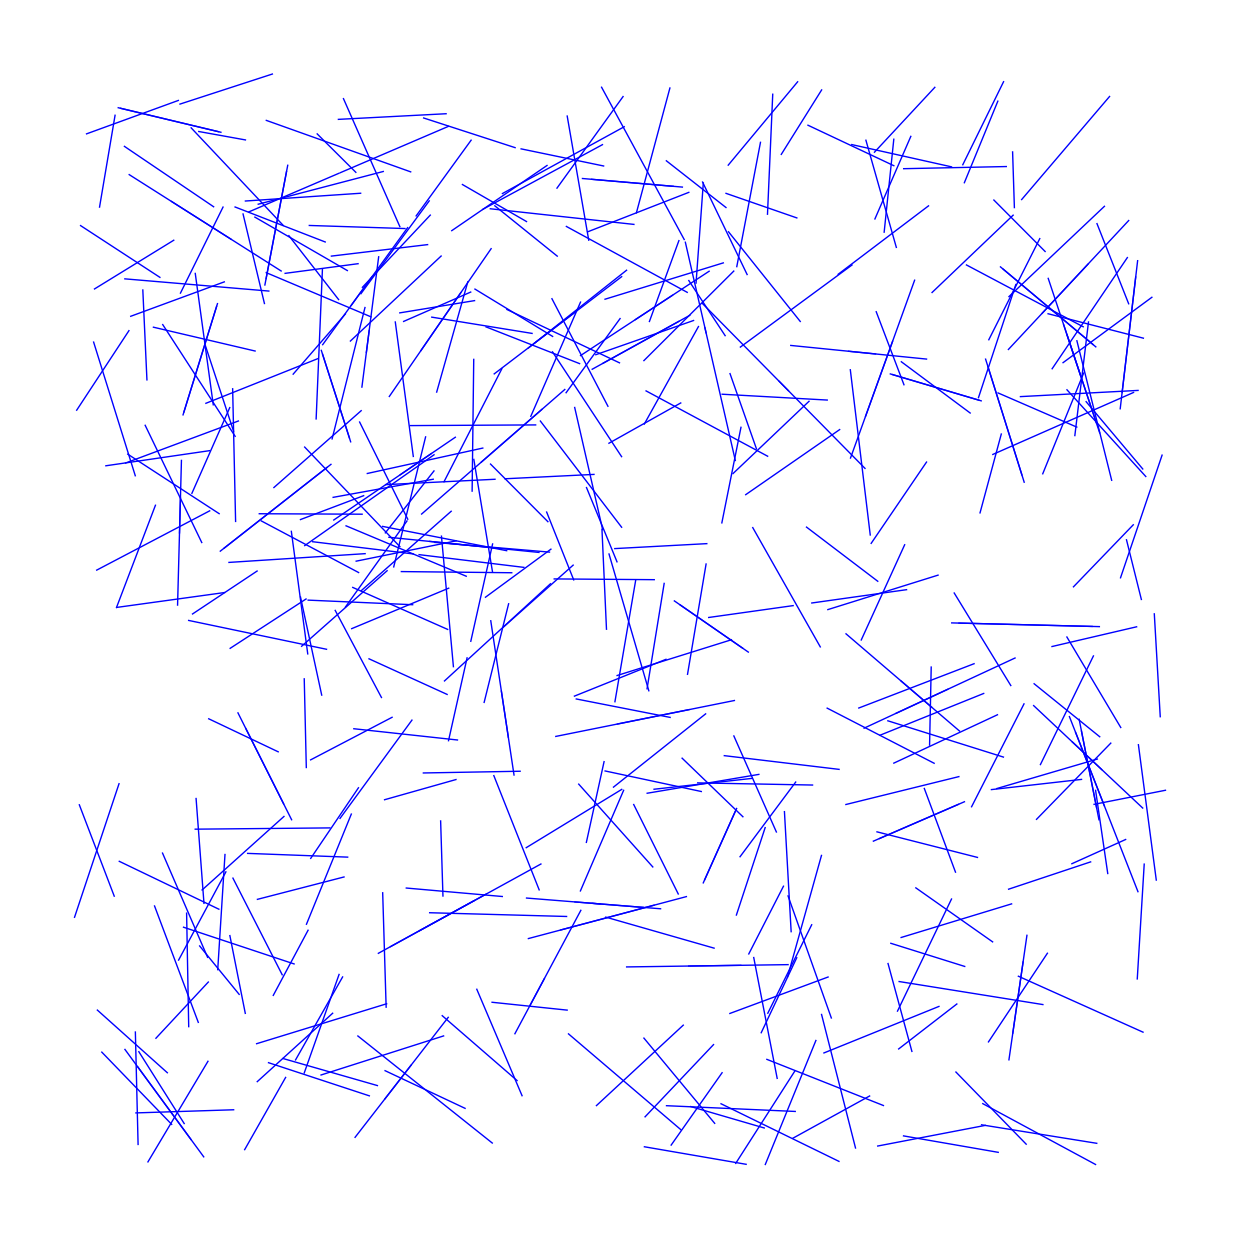

In [96]:
# 1. Define particle behavior parameters
params = {
    'p_run': 0.5,           # 50% chance of running
    'p_tumble': 0.5,        # 50% chance of tumbling
    'speed': 0.05,          # Distance per time step
    'p_link': 0.2,          # 20% chance of laying a link per step
    'L_link_mean': 0.1,     # Average link length
    'L_link_std': 0.02      # Std deviation of link length
}

# 2. Run the simulation
steps = 25
N = 100
dt = 1.0

simulate(N=N, steps=steps, dt=dt, particle_params=params)

# 3. Optional: Visualize the raw links and deposition points
plot_network(nodes, edges, step=steps)

In [99]:
from StructuralGT.networks import Network

Dynamics = Network('Dynamics')

In [100]:
from StructuralGT import Binarizer

B = Binarizer('Dynamics/dynamics_1.tif')

interactive(children=(Dropdown(description='Threshold', layout=Layout(display='flex', flex_flow='row', justify…

In [67]:
Dynamics.binarize()

Ran img_to_skel() in  0.03644204139709473 for skeleton with  9965 voxels


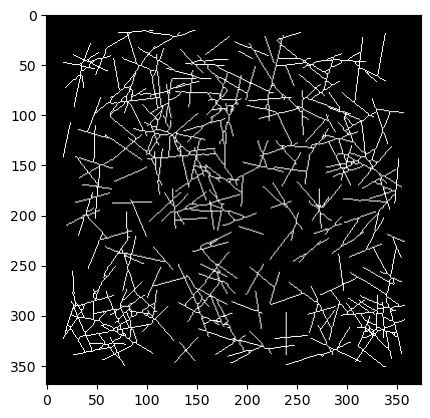

In [68]:
Dynamics.img_to_skel()
plt.imshow(Dynamics.skeleton, cmap='gray')

In [69]:
Dynamics.set_graph(sub=False)

implicit data copy when writing chunk: log/Edge_lens
implicit data copy when writing chunk: log/Node_lens


In [70]:
A = Dynamics.graph.get_adjacency()
print(A.shape)

(893, 893)


<Axes: >

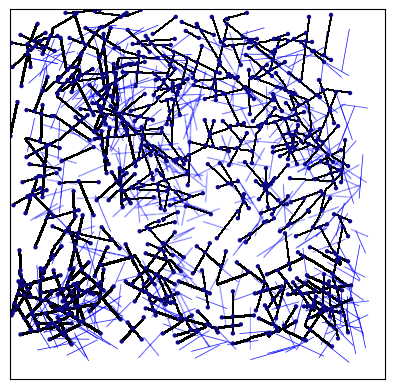

In [71]:
Dynamics.graph_plot()

## Network properties

**Diameter**: maximum number of edges to reach one node from any other node

**Density**: the fraction of edges that exist compared to all possible edges in a complete graph, given by $2e / n(n-1)$.

**Clustering coefficient**: the fraction of neighbors of a node that are directly connected to each other as well (forming a triangle), given by $2T_i / k_i (k_i-1)$, where $T_i$ is the number of connected triples on node $i$. 

In [16]:
from StructuralGT.structural import Size

S = Size()
S.compute(Dynamics)
print(f'Number of nodes is {S.number_of_nodes}')
print(f'Number of edges is {S.number_of_edges}')
print(f'Diameter is {S.diameter}')
print(f'Density (fraction of edges that exist compared to all possible edges in a complete graph) is {S.density}')

Number of nodes is 913
Number of edges is 1163
Diameter is 71
Density (fraction of edges that exist compared to all possible edges in a complete graph) is 0.0027934705328490996


Average degree is 2.547645125958379


(array([343.,  34., 354., 116.,   0.,  35.,  14.,   9.,   5.,   3.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

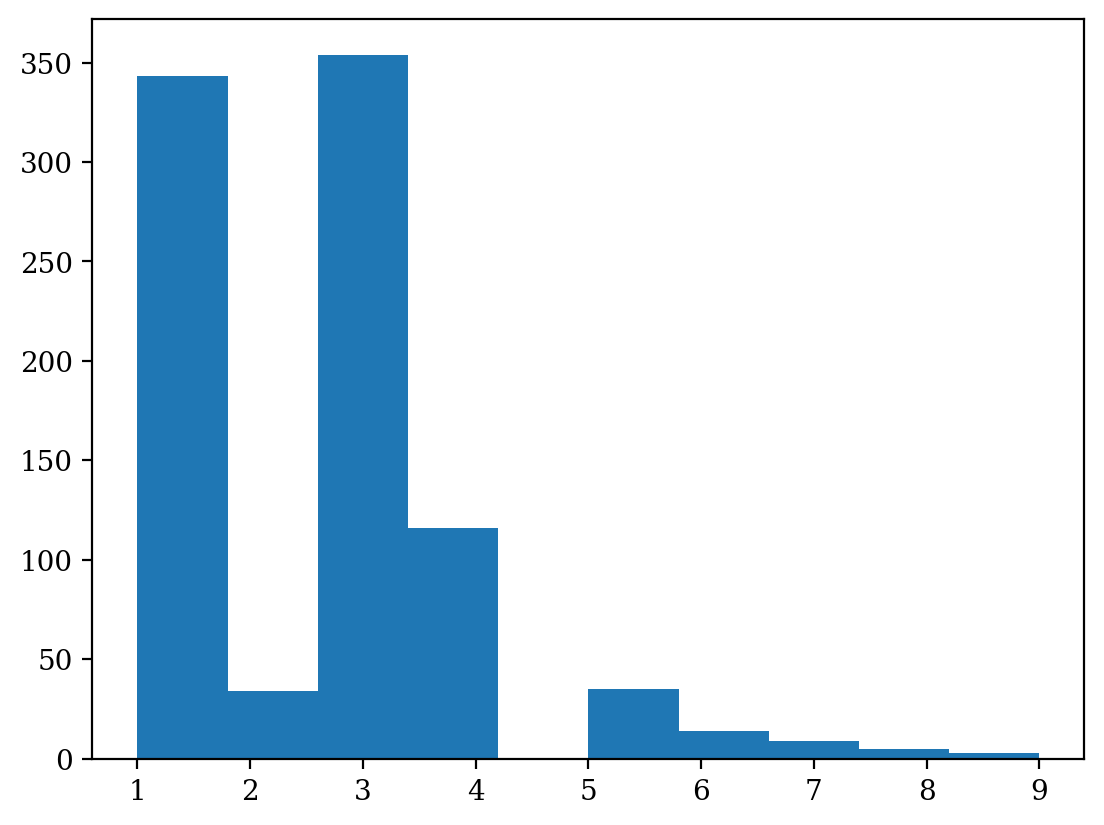

In [17]:
from StructuralGT.structural import Degree

D = Degree()
D.compute(Dynamics)
print(f'Average degree is {D.average_degree}')
plt.hist(D.degree)

<Axes: >

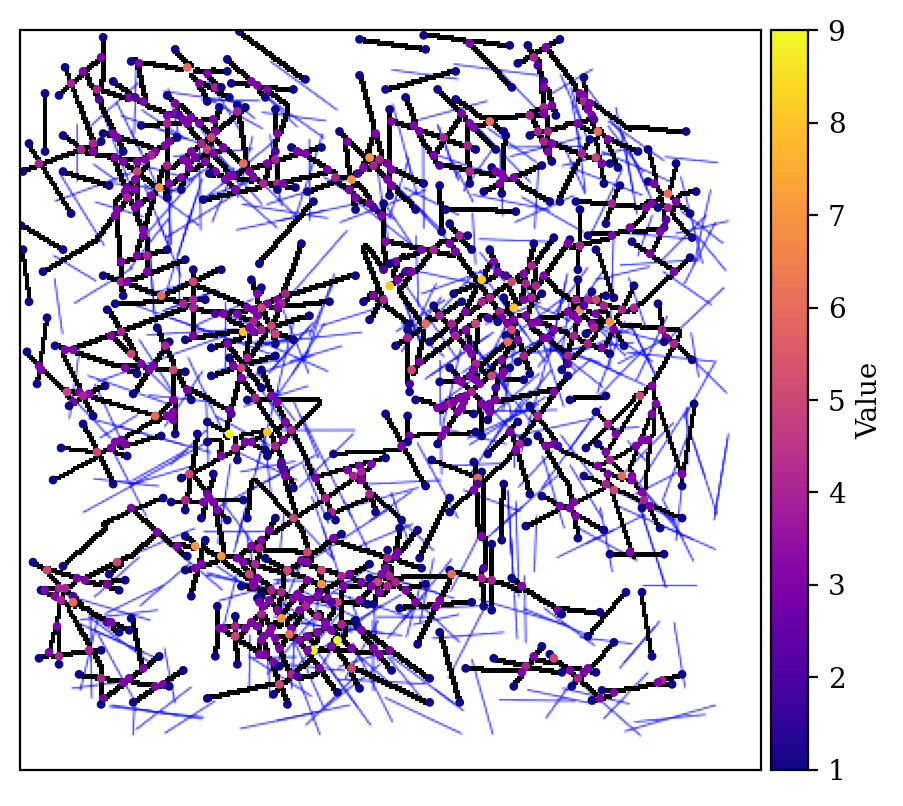

In [18]:
Dynamics.node_plot(parameter=D.degree)

Average clustering coefficient is 0.059928023783445465


(array([709.,  21.,  50.,   4.,   1., 126.,   0.,   0.,   0.,   2.]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667]),
 <BarContainer object of 10 artists>)

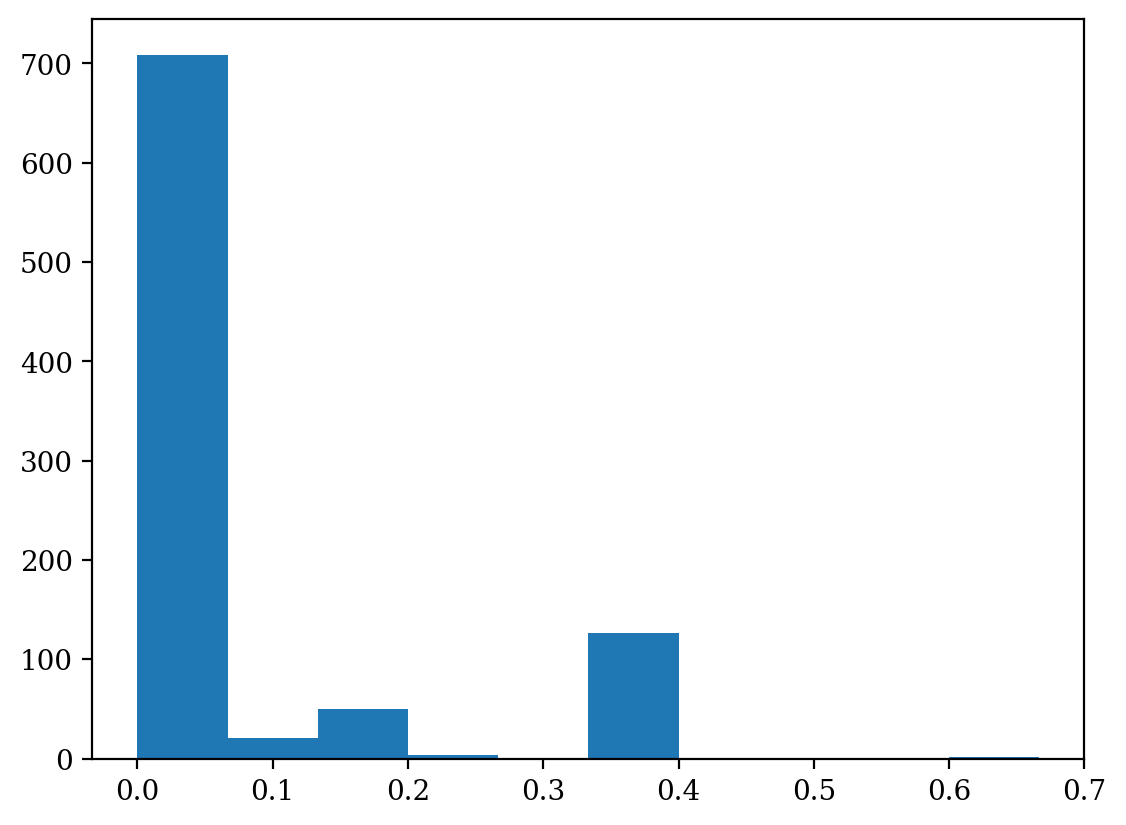

In [19]:
from StructuralGT.structural import Clustering

C = Clustering()
C.compute(Dynamics)

print(f'Average clustering coefficient is {C.average_clustering_coefficient}')

plt.hist(C.clustering)

## Network 2

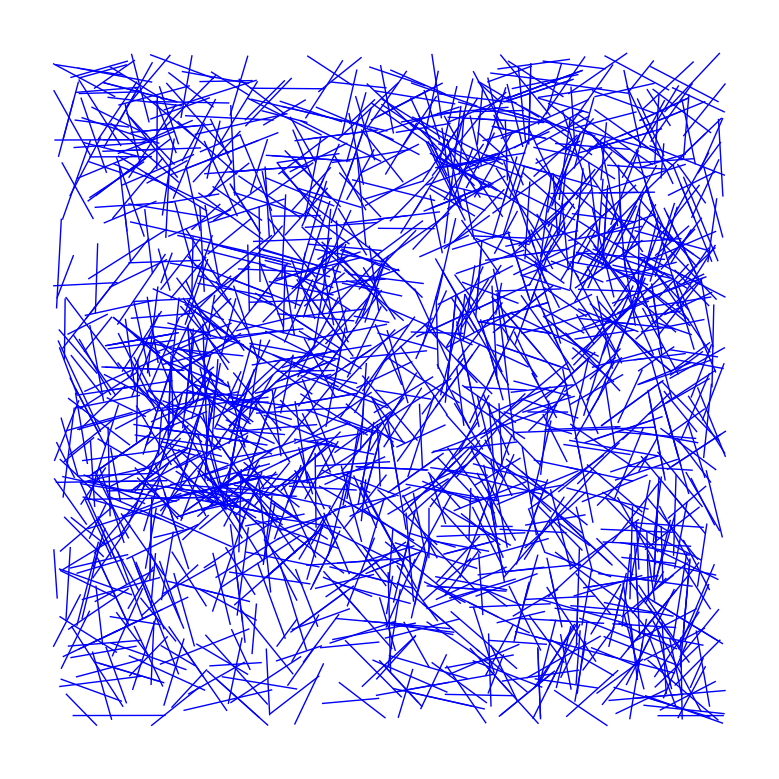

In [20]:
# 1. Define particle behavior parameters
params = {
    'p_run': 0.5,           # 50% chance of running
    'p_tumble': 0.5,        # 50% chance of tumbling
    'speed': 0.05,          # Distance per time step
    'p_link': 0.2,          # 20% chance of laying a link per step
    'L_link_mean': 0.1,     # Average link length
    'L_link_std': 0.02      # Std deviation of link length
}

# 2. Run the simulation
steps = 100
N = 100
dt = 1.0

simulate(N=N, steps=steps, dt=dt, particle_params=params)

# 3. Optional: Visualize the raw links and deposition points
plot_network(nodes, edges, step=steps)

In [23]:
from StructuralGT.networks import Network

Dynamics = Network('Dynamics')

In [25]:
from StructuralGT import Binarizer

B = Binarizer('Dynamics/dynamics_1.tif')

interactive(children=(Dropdown(description='Threshold', layout=Layout(display='flex', flex_flow='row', justify…

In [26]:
Dynamics.binarize()

Ran img_to_skel() in  0.058861732482910156 for skeleton with  25160 voxels


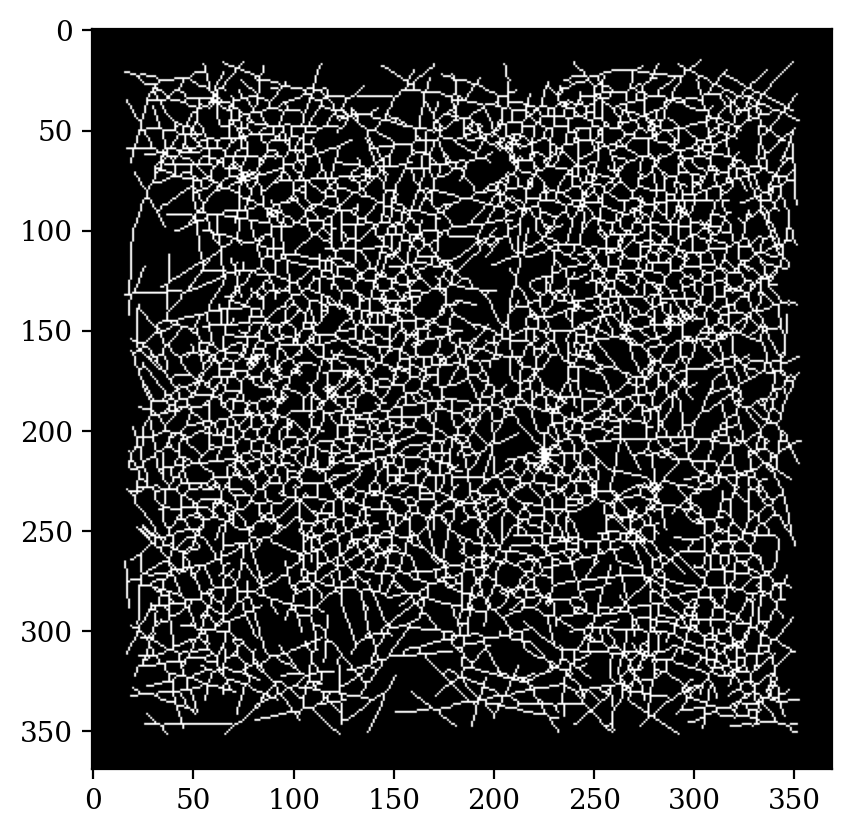

In [27]:
Dynamics.img_to_skel()
plt.imshow(Dynamics.skeleton, cmap='gray')

In [28]:
Dynamics.set_graph(sub=False)

implicit data copy when writing chunk: log/Edge_lens
implicit data copy when writing chunk: log/Node_lens


In [29]:
A = Dynamics.graph.get_adjacency()
print(A.shape)

(2803, 2803)


<Axes: >

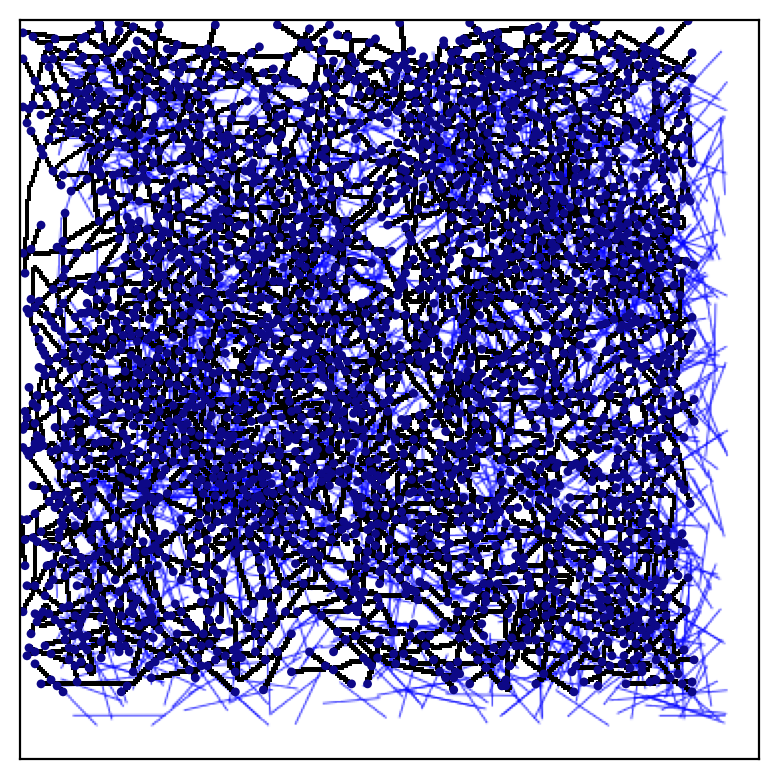

In [30]:
Dynamics.graph_plot()

In [31]:
from StructuralGT.structural import Size

S = Size()
S.compute(Dynamics)
print(f'Number of nodes is {S.number_of_nodes}')
print(f'Number of edges is {S.number_of_edges}')
print(f'Diameter is {S.diameter}')
print(f'Density (fraction of edges that exist compared to all possible edges in a complete graph) is {S.density}')

Number of nodes is 2803
Number of edges is 5071
Diameter is 69
Density (fraction of edges that exist compared to all possible edges in a complete graph) is 0.001291315540120545


Average degree is 3.6182661434177668


<Axes: >

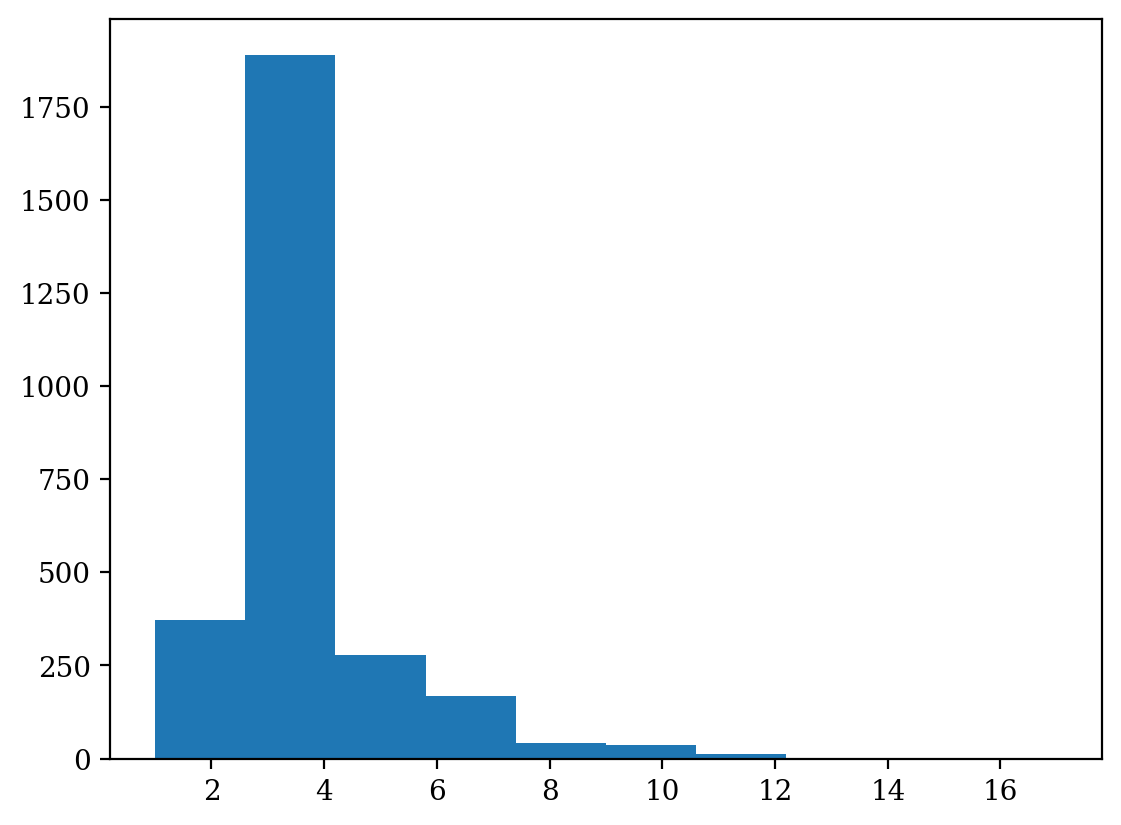

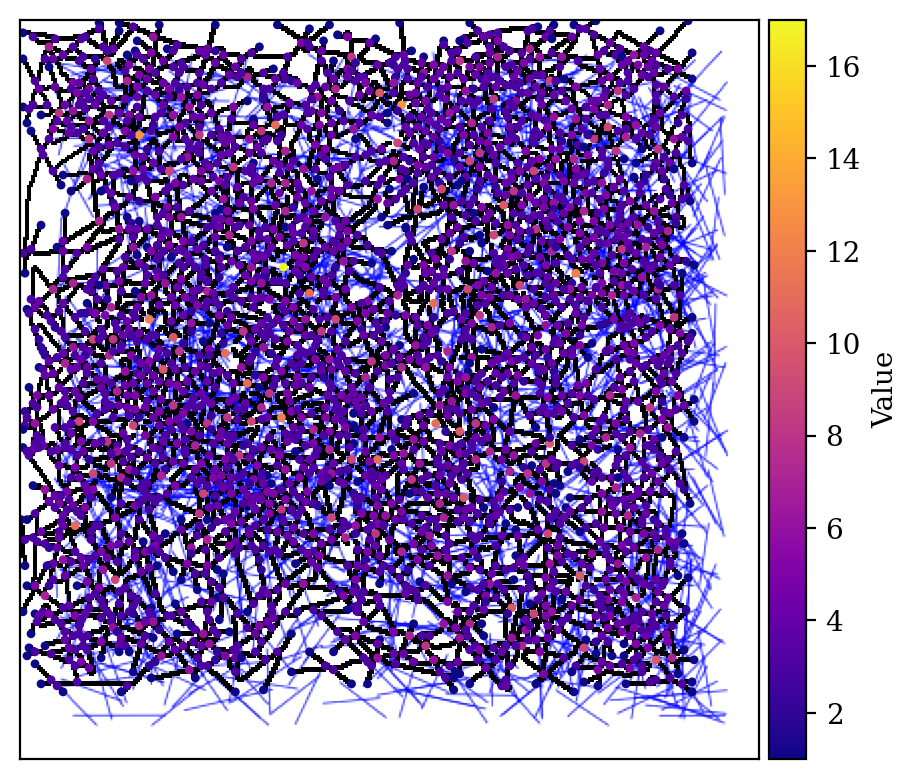

In [32]:
from StructuralGT.structural import Degree

D = Degree()
D.compute(Dynamics)
print(f'Average degree is {D.average_degree}')
plt.hist(D.degree)
Dynamics.node_plot(parameter=D.degree)

Average clustering coefficient is 0.14949310807320085


(array([1341.,  476.,  186.,  701.,    4.,   20.,   53.,    0.,    0.,
          22.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

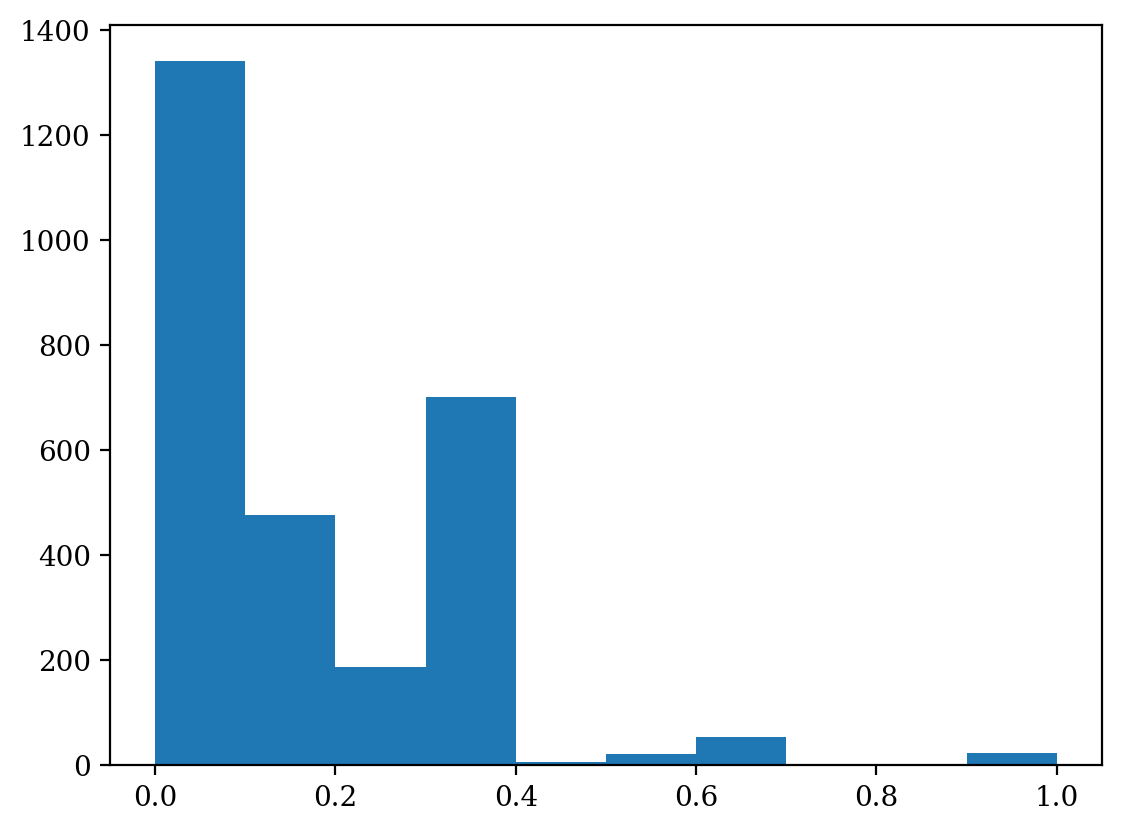

In [33]:
from StructuralGT.structural import Clustering

C = Clustering()
C.compute(Dynamics)

print(f'Average clustering coefficient is {C.average_clustering_coefficient}')

plt.hist(C.clustering)

In [34]:
from StructuralGT.structural import Assortativity

A = Assortativity()
A.compute(Dynamics)

print(f'Assortativity is {A.assortativity}')

Assortativity is 0.09707457375029073
